# Generate Flowers with Text Description

please download source data at kaggle:
    https://www.kaggle.com/c/datalab-cup3-reverse-image-caption-2020/data

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, RepeatVector, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, UpSampling2D
import os
from tensorflow.keras.activations import sigmoid, softmax
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display
from zipfile import ZipFile

# import seaborn as sns
# sns.set()
import gensim
import gensim.downloader

In [3]:
# download pretrained word vector of 100-dimension
wv = gensim.downloader.load('glove-wiki-gigaword-100')

## Preprocess Text

Notice: I added comments if I used part of preprocessing codes offered by the kaggle competition organizer. https://nthu-datalab.github.io/ml/competitions/Comp_03_Reverse-Image-Caption/03_Reverse-Image-Caption.html

In [8]:
# use: kaggle organizer instruction
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [9]:
# by jvmh
emb_weight_mat = np.zeros((len(word2Id_dict), 100), dtype=np.float32)
for i in range(len(word2Id_dict)):
    if id2word_dict[str(i)] in wv:
        emb_weight_mat[i, :] = wv[id2word_dict[str(i)]]

In [10]:
# reference: kaggle organizer instruction
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l # padding length
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, 
    # and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [11]:
# by jvmh
data_path = './dataset'
# with ZipFile('dataset.zip', 'r') as zf:
#     zf.extractall()
df = pd.read_pickle(data_path + '/text2ImgData.pkl')

In [12]:
# by jvmh
n_images_train = int(0.99 * len(df))
n_images_test = len(df) - n_images_train
print('There are %d image in training data' % (n_images_train))
print('There are %d image in test data' % (n_images_test))

There are 7296 image in training data
There are 74 image in test data


In [13]:
df

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg
...,...,...
8043,"[[4, 1, 5, 2, 10, 6, 20, 3, 11, 7, 79, 5427, 5...",./102flowers/image_08043.jpg
8044,"[[8, 369, 403, 1, 7, 8, 71, 103, 3, 8, 21, 268...",./102flowers/image_08044.jpg
8045,"[[4, 1, 15, 14, 3, 11, 13, 18, 7, 2, 10, 6, 10...",./102flowers/image_08045.jpg


In [14]:
# by jvmh
train_index = random.sample(range(len(df)), n_images_train)
test_index = [i for i in range(len(df)) if i not in train_index]
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]

In [15]:
train_df.head(3)

,Captions,ImagePath
ID,,
6265,"[[4, 15, 8, 25, 1, 7, 11, 2, 3, 20, 19, 5427, ...",./102flowers/image_06265.jpg
7057,"[[9, 2, 27, 4, 1, 6, 12, 7, 11, 19, 5427, 5427...",./102flowers/image_07057.jpg
8106,"[[9, 1, 15, 133, 3, 5, 2, 10, 6, 78, 54, 92, 3...",./102flowers/image_08106.jpg


In [16]:
# offered by organize, but most not used later.
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256, #64*64,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 2e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': n_images_train,               # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 25                          # printing frequency of loss
}

In [17]:
# reference: kaggle organizer instruction
# changed by jvmh

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    short_side = tf.minimum(tf.shape(img)[0], tf.shape(img)[1])
    img = tf.image.resize_with_crop_or_pad(img, short_side, short_side)
    img = tf.image.resize(img, size=[int(IMAGE_HEIGHT * 1.2), int(IMAGE_WIDTH * 1.2)])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_crop(img, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    return img

def dataset_generator(df, batch_size, data_generator):
    """
    load the training data into two NumPy arrays
    """
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    captions = df['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    
    image_path = df['ImagePath'].values
    images = [data_generator(i) for i in image_path]
    dataset = tf.data.Dataset.from_tensor_slices((images, caption))
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [18]:
train_dataset = dataset_generator(train_df, hparas['BATCH_SIZE'], training_data_generator)

## TextEncoder

In [19]:
# designed and developed by jvmh
class TextEncoder(tf.keras.Model):
    """
    Embed text (words) into 100 dimension
    Use pretrained work vector: gensim.downloader.load('glove-wiki-gigaword-100')
    Input: text of lengh 20
    Output: a 100D vector
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.embedding = layers.Embedding(
            self.hparas['VOCAB_SIZE'],
            100,
            embeddings_initializer=tf.keras.initializers.Constant(emb_weight_mat)
        )
    
    def call(self, text):
        x = self.embedding(text)
        output = tf.reduce_mean(x, axis=1)
        return output

## Generator

In [20]:
# designed and developed by jvmh
class Generator(tf.keras.Model):
    """
    Generate fake images
    input: embeded text, noise
    output: fake images with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.bn0a = BatchNormalization()
        self.d0a = Dense(1024)
        self.bn0b = BatchNormalization()
        self.relu0 = LeakyReLU()
        self.d0b = Dense(4 * 4 * 512)
        
        self.bn1 = BatchNormalization()
        self.relu1 = LeakyReLU()
        self.conv1 = Conv2DTranspose(512, 3, strides=1, padding='same')
        
        self.bn2a = BatchNormalization()
        self.relu2a = LeakyReLU()
        self.conv2a = Conv2DTranspose(256, 3, strides=2, padding='same')
        self.bn2b = BatchNormalization()
        self.relu2b = LeakyReLU()
        self.conv2b = Conv2DTranspose(256, 3, strides=1, padding='same')
        self.conv2c = Conv2D(256, 1, strides=1, padding='same')
        self.up2c = UpSampling2D((2, 2))
        
        self.bn3a = BatchNormalization()
        self.relu3a = LeakyReLU()
        self.conv3a = Conv2DTranspose(128, 3, strides=2, padding='same')
        self.bn3b = BatchNormalization()
        self.relu3b = LeakyReLU()
        self.conv3b = Conv2DTranspose(128, 3, strides=1, padding='same')
        self.conv3c = Conv2D(128, 1, strides=1, padding='same')
        self.up3c = UpSampling2D((2, 2))
        
        self.bn4a = BatchNormalization()
        self.relu4a = LeakyReLU()
        self.conv4a = Conv2DTranspose(64, 3, strides=2, padding='same')
        self.bn4b = BatchNormalization()
        self.relu4b = LeakyReLU()
        self.conv4b = Conv2DTranspose(64, 3, strides=1, padding='same')
        self.conv4c = Conv2D(64, 1, strides=1, padding='same')
        self.up4c = UpSampling2D((2, 2))
        
        self.bn5a = BatchNormalization()
        self.relu5a = LeakyReLU()
        self.conv5a = Conv2DTranspose(16, 3, strides=2, padding='same')
        self.bn5b = BatchNormalization()
        self.relu5b = LeakyReLU()
        self.conv5b = Conv2DTranspose(3, 3, strides=1, padding='same')
        self.flag = True
        
    def call(self, text, noise_z):
        # generation is a process of upsampling!
        # an inverse process to dicriminator!
        if self.flag:
            print("text shape", text.shape)
            self.flag = False
        
        x = tf.concat([noise_z, text], axis=-1) # column
        x = self.bn0a(x)
        x = self.d0a(x)
        x = self.bn0b(x)
        x = self.relu0(x)
        x = self.d0b(x)
        x = tf.reshape(x, [-1, 4, 4, 512])
        
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        
        r = self.conv2c(x)
        r = self.up2c(r)
        x = self.bn2a(x)
        x = self.relu2a(x)
        x = self.conv2a(x)
        x = self.bn2b(x)
        x = self.relu2b(x)
        x = self.conv2b(x)
        x = x + r
        
        r = self.conv3c(x)
        r = self.up3c(r)
        x = self.bn3a(x)
        x = self.relu3a(x)
        x = self.conv3a(x)
        x = self.bn3b(x)
        x = self.relu3b(x)
        x = self.conv3b(x)
        x = x + r
        
        r = self.conv4c(x)
        r = self.up4c(r)
        x = self.bn4a(x)
        x = self.relu4a(x)
        x = self.conv4a(x)
        x = self.bn4b(x)
        x = self.relu4b(x)
        x = self.conv4b(x)
        x = x + r
        
        x = self.bn5a(x)
        x = self.relu5a(x)
        x = self.conv5a(x)
        x = self.bn5b(x)
        x = self.relu5b(x)
        x = self.conv5b(x)
        x = sigmoid(x) # assert: values are in [0, 1]
        return x

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

## Discriminator

In [23]:
# designed and developed by jvmh
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image, embedded text
    output: probability of being a real image (logits, not real probability)
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.d0 = Dense(128)
        
        self.relu1 = LeakyReLU()
        self.conv1 = Conv2D(32, 3, strides=2, padding='same')
        
        self.bn2a = BatchNormalization()
        self.relu2a = LeakyReLU()
        self.conv2a = Conv2D(64, 3, strides=2, padding='same')
        self.bn2b = BatchNormalization()
        self.relu2b = LeakyReLU()
        self.conv2b = Conv2D(64, 3, strides=1, padding='same')
        self.conv2c = Conv2D(64, 3, strides=2, padding='same')
        
        self.bn3a = BatchNormalization()
        self.relu3a = LeakyReLU()
        self.conv3a = Conv2D(128, 3, strides=2, padding='same')
        self.bn3b = BatchNormalization()
        self.relu3b = LeakyReLU()
        self.conv3b = Conv2D(128, 3, strides=1, padding='same')
        self.conv3c = Conv2D(128, 3, strides=2, padding='same')
        
        self.conv4 = Conv2D(256, 8, strides=1, padding='same')
        self.flatten = Flatten()
        
        self.d5 = Dense(256)
        self.relu6 = LeakyReLU()
        self.d6 = Dense(1)
        
    def call(self, x, z):
        # extract abstract characteristics for 0-1 prediction
        # 1: real image
        # 0: fake image
        x = self.relu1(x)
        x = self.conv1(x)
        
        r = self.conv2c(x)
        x = self.bn2a(x)
        x = self.relu2a(x)
        x = self.conv2a(x)
        x = self.bn2b(x)
        x = self.relu2b(x)
        x = self.conv2b(x)
        x = x + r
        
        r = self.conv3c(x)
        x = self.bn3a(x)
        x = self.relu3a(x)
        x = self.conv3a(x)
        x = self.bn3b(x)
        x = self.relu3b(x)
        x = self.conv3b(x)
        x = x + r
        
        x = self.conv4(x)
        x = self.flatten(x)
        x = tf.concat([x, z], axis=-1)
        
        x = self.d5(x)
        x = self.relu6(x)
        x = self.d6(x)
        
        return x

In [25]:
# cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

## Define Loss & Acc

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
# designed and developed by jvmh

def discriminator_loss(real_logits, fake_logits):
    L = len(real_logits)
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones(L), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros(L), fake_logits)
    total_loss =real_loss + fake_loss
    return total_loss


def discriminator_acc(real_logits, fake_logits):
    acc = (real_logits >= 0.0).numpy().mean() + (fake_logits < 0.0).numpy().mean() # hope to be 0.5
    return acc / 2.0
 
    
def generator_loss(fake_logits):
    # for discriminator, output value of fake image should be 0
    # but generator expects to confuse the discriminator
    L = len(fake_logits)
    return cross_entropy(tf.ones(L), fake_logits)

def generator_acc(fake_logits):
    return (fake_logits >= 0.0).numpy().mean()
 

In [28]:
# def decayed_learning_rate(step):
#     return 1e-4 * 0.99**(step / 640.0)
# decayed_learning_rate(600*100)

In [29]:
int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])

114

## Adam Optimizer

In [30]:
# designed and developed by jvmh
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    2e-4,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

In [31]:

# Use Adam for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)

text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [32]:
# reference: offered by organizer
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Preparations

In [33]:
# most by jvmh

def train_step(real_image, caption, epoch):
    
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embed = text_encoder(caption)
        fake_image = generator(text_embed, noise)
        real_output = discriminator(real_image, text_embed)
        fake_output = discriminator(fake_image, text_embed)
       
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    g_acc = generator_acc(fake_output)
    d_acc = discriminator_acc(real_output, fake_output)
    
    return g_loss,  g_acc, d_loss, d_acc

In [34]:
def test_step(caption, noise):
    text_embed= text_encoder(caption)
    print("test encoder")
    fake_image = generator(text_embed, noise)
    return fake_image

In [35]:
import os
if not os.path.exists("./samples/demo"):
    os.makedirs("./samples/demo")

In [36]:
# reference: offered by kaggle organizer
# changed by jvmh
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    return plt.imsave(path, merge(images, size))

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [37]:
import math

In [38]:
# this sample is offered by kaggle organizer
# changed by jvmh
sample_sentence = ["the flower shown has red anther pink pistil and bright yellow petals.",
                   "the flower shown has yellow anther red pistil and bright red petals.",
                   "the petals on this flower are white with a yellow center",
                   "this flower has a lot of small round pink petals.",
                   "this flower is orange in color, and has petals that are ruffled and rounded.",
                   "the flower has yellow petals and the center of it is brown.",
                   "this flower has petals that are blue and white.",
                   "these white flowers have petals that start off white in color and end in a white towards the tips."] * 8
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(len(sample_sentence), hparas['Z_DIM'])).astype(np.float32)
for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, len(sample_sentence))

In [39]:
# for caption in sample_sentence:
#     #print(caption.shape)
#     fake_image = test_step(caption, sample_seed)#, text_encoder.initialize_hidden_state())
 
#     save_images(fake_image, [8, 8], 'samples/demo/test.jpg')
#     plt.imshow(plt.imread('samples/demo/test.jpg'))
#     plt.axis('off')
#     plt.show()

In [40]:
# hparas['PRINT_FREQ']=2
# hparas['N_EPOCH']=600

In [41]:
int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])

114

In [42]:
# trained 200 epochs, 50 minutes
# when training, I saved generated flowers once every several epochs
# therefore, there is no need for a separate testing step

from tqdm import tqdm
def train(dataset, epochs, d_loss_list, d_acc_list, g_loss_list, g_acc_list):

    steps_per_epoch = int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])
    for epoch in tqdm(range(hparas['N_EPOCH'])):
        g_total_loss = 0
        d_total_loss = 0
        
        start = time.time()
        for image, caption in dataset:
            g_loss, g_acc, d_loss, d_acc = train_step(image, caption, epoch)
            g_total_loss += g_loss
            d_total_loss += d_loss
            g_loss_list.append(g_loss)
            g_acc_list.append(g_acc)
            d_loss_list.append(d_loss)
            d_acc_list.append(d_acc)
        
        if not (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            continue
        
# Below might be useful when you are tuning hyperparameters.

#         print("-"*60)
#         time_tuple = time.localtime()
#         time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
#         print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
#                                                                      g_total_loss/steps_per_epoch,
#                                                                      d_total_loss/steps_per_epoch))
#         print("Epoch {}, gen_acc: {:.4f}, disc_acc: {:.4f}".format(epoch+1,
#                                                                      np.mean(g_acc_list[-steps_per_epoch:]),
#                                                                      np.mean(d_acc_list[-steps_per_epoch:])))        
#         print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
#         fake_image=None
        for caption in sample_sentence:
            fake_image = test_step(caption, sample_seed)
       
        save_images(fake_image, [8, 8], 'samples/demo/train_{:03d}.jpg'.format(epoch+1))
        plt.figure(figsize=(8, 8))
        plt.imshow(plt.imread('samples/demo/train_{:03d}.jpg'.format(epoch+1)))
        plt.axis('off')
        plt.show()

    return d_loss_list, d_acc_list, g_loss_list, g_acc_list

## Training & Results

images generated are in the folder "images"

Text(0.5, 0, 'epoch')

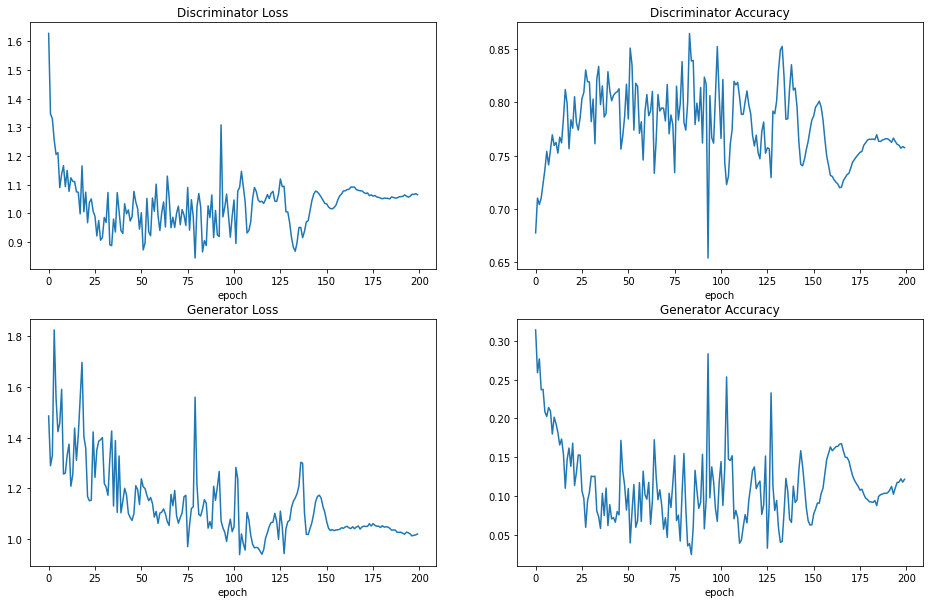

In [45]:
# by jvmh

d_loss_list, d_acc_list, g_loss_list, g_acc_list = [], [], [], []
d_loss_list, d_acc_list, g_loss_list, g_acc_list = train(train_dataset, hparas['N_EPOCH'], d_loss_list, d_acc_list, g_loss_list, g_acc_list)

def batch_to_epoch(lst, n = int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])):
    res = []
    for i in range(len(lst) // n):
        res.append(np.mean(lst[i * n: (i + 1) * n]))
    return res

d_loss_epoch, d_acc_epoch, g_loss_epoch, g_acc_epoch = \
batch_to_epoch(d_loss_list), batch_to_epoch(d_acc_list), batch_to_epoch(g_loss_list), batch_to_epoch(g_acc_list)


fig, axes = plt.subplots(2,2, figsize=(16, 10))
 
axes[0][0].plot(range(len(d_loss_epoch)), d_loss_epoch)
axes[0][0].set_title('Discriminator Loss')
axes[0][0].set_xlabel('epoch')

axes[1][0].plot(range(len(g_loss_epoch)), g_loss_epoch)
axes[1][0].set_title('Generator Loss')
axes[1][0].set_xlabel('epoch')


axes[0][1].plot(range(len(d_acc_epoch)), d_acc_epoch)
axes[0][1].set_title('Discriminator Accuracy')
axes[0][1].set_xlabel('epoch')

axes[1][1].plot(range(len(g_acc_epoch)), g_acc_epoch)
axes[1][1].set_title('Generator Accuracy')
axes[1][1].set_xlabel('epoch')

In [52]:
fig.savefig('plot.png')